In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x582f8000 @  0x7f9b3fdbc2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:

def save_checkpoint(state, is_best, checkpoint,time):
    """Saves model and training parameters at checkpoint + 'last.pth.tar'. If is_best==True, also saves
    checkpoint + 'best.pth.tar'
    Args:
        state: (dict) contains model's state_dict, may contain other keys such as epoch, optimizer state_dict
        is_best: (bool) True if it is the best model seen till now
        checkpoint: (string) folder where parameters are to be saved
    """
    filepath = os.path.join(checkpoint,str(time)+ 'last.pth.tar')
    if not os.path.exists(checkpoint):
        print("Checkpoint Directory does not exist! Making directory {}".format(checkpoint))
        os.mkdir(checkpoint)
    else:
        print("Checkpoint Directory exists! ")
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint,str(time)+ 'best.pth.tar'))


def load_checkpoint(checkpoint, model, optimizer=None):
    """Loads model parameters (state_dict) from file_path. If optimizer is provided, loads state_dict of
    optimizer assuming it is present in checkpoint.
    Args:
        checkpoint: (string) filename which needs to be loaded
        model: (torch.nn.Module) model for which the parameters are loaded
        optimizer: (torch.optim) optional: resume optimizer from checkpoint
    """
    if not os.path.exists(checkpoint):
        raise("File doesn't exist {}".format(checkpoint))
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optim_dict'])

    return checkpoint

In [4]:
import numpy as np # NumPy is the fundamental package for scientific computing
import time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd 
pd.set_option('display.max_columns', None) 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore') 
import datetime
import json
import logging
import os
import shutil
import regex
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.utils.data
from torch.autograd import Variable
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import neighbors 
from sklearn.metrics import mean_squared_error 
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeRegressor
from math import log
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
#from pyvi import ViTokenizer

Using TensorFlow backend.


Sử dụng hàm này để chuẩn hóa và lọc những từ không liên quan đến phân loại .

Trước tiên ta chuyển đổi các chữ thành kiểu chữ thường rồi ta sử dụng regex để xóa bỏ các từ không phải là chữ rồi chuyển sang mảng chứa các từ của câu, sau đó là định nghĩa ra một mảng các từ không  liên quan rồi  là lọc ra các từ không liên quan .Ta cho mảng chứa các chữ của câu đầu vào chạy qua mảng các từ không liên quan chữ nào không có trong mảng các từ không liên quan thì giữ lại và tạo thành mảng mới.Rồi từ mảng đó ta ghép các từ lại cho ra câu văn sau xử lý

In [0]:
def replace_words(text):
   
    text=text.lower()
    text = regex.sub('[^\p{Latin}\n\t\s]', ' ', text).strip()
    bagtext=text.split()
    listremove=[]
    textlist=["m","giá","triệu","xm","dt","lh","tỷ","trm","hotline","tr","mxm", "x" ,"t","tl","p","q","tp","ql","hcm","hn"]
    for word in bagtext:
      for i in textlist:
        if str(word) == str(i) and len(word)==len(i):
          listremove.append(word)

    for word in listremove:
      bagtext.remove(word)
    text=""
    for i in bagtext:
      text+=i+" "
    
    
    return text.strip()

Đọc dữ liệu từ tập tin .csv vì chúng em chỉ sử dụng cột 'HouseTypeCssClass' và 'Title' nên tụi em bỏ cột  'Content' và 'Id'

In [0]:
data=pd.read_csv("drive/My Drive/DataSet/bds_02.csv");
data=data.drop(['Id','Content'],axis=1)

Kiểm tra số dòng và kiểu dữ liệu trong data

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992 entries, 0 to 4991
Data columns (total 2 columns):
Title                4992 non-null object
HouseTypeCssClass    4992 non-null object
dtypes: object(2)
memory usage: 78.1+ KB


Tiếp theo là kiểm tra kích thước của tập dữ liệu

In [34]:
data.shape

(4992, 2)

Dữ liệu gồm 4992 dòng và 42cột, tương ứng với một bộ (4992, 2)

Thử hiển thị một số dòng để xem đã đọc đúng hay chưa

In [9]:
data.head(5)

,Title,HouseTypeCssClass
0,"Cho thuê kho xưởng tại KCN Hà Bình Phương, Thư...",tp-warehouse
1,"Cần bán kho xưởng đường Nguyễn Duy Trinh, P. L...",tp-warehouse
2,Tại KCN Quốc Oai Hà Nội cho thuê kho xưởng,tp-warehouse
3,"Kho,xưởng ở Linh Đông Thủ Đức 500M2 GIÁ 20 TRIỆU",tp-warehouse
4,"Cho thuê kho 1200m2 tại thủ dầu một, bình dươn...",tp-warehouse


Áp dụng hàm xử lý (replace_words) vào cột tiêu đề (Title) của data

In [0]:
data['Title'] = data['Title'].apply(replace_words)

Thử hiển thị một số dòng để xem đã xử lý đúng hay chưa

In [11]:
data.head(5)

,Title,HouseTypeCssClass
0,cho thuê kho xưởng tại kcn hà bình phương thườ...,tp-warehouse
1,cần bán kho xưởng đường nguyễn duy trinh long ...,tp-warehouse
2,tại kcn quốc oai hà nội cho thuê kho xưởng,tp-warehouse
3,kho xưởng ở linh đông thủ đức,tp-warehouse
4,cho thuê kho tại thủ dầu một bình dương cho,tp-warehouse


Vẽ biểu đồ

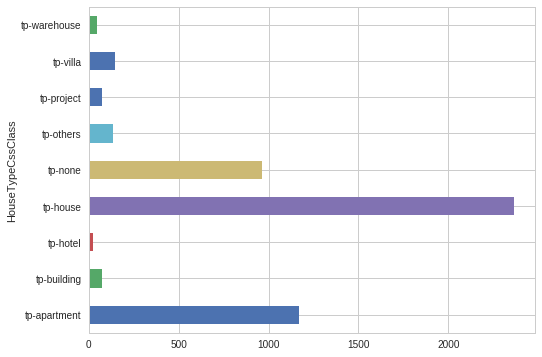

In [12]:
fig = plt.figure(figsize=(8,6))
data.groupby('HouseTypeCssClass').HouseTypeCssClass.count().plot.barh()
plt.show()

Đếm số lượng các nhãn (HouseTypeCssClass)

In [13]:
data['HouseTypeCssClass'].value_counts()

tp-house        2366
tp-apartment    1169
tp-none          962
tp-villa         146
tp-others        132
tp-project        76
tp-building       71
tp-warehouse      45
tp-hotel          25
Name: HouseTypeCssClass, dtype: int64

Sử dụng Bag of Words để phân loại .Thực hiện đếm từ ở tập huấn luyện. Kết quả trả về là ma trận các mẫu từ và số lần xuất hiện.Sau đó chuyển chúng sang dạng array để chút nữa sẽ chuyển sang dạng tensor. 

In [14]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data['Title'])
x=X_train_counts.toarray()
y=data['HouseTypeCssClass'].map({'tp-house': 0, 'tp-apartment': 1,'tp-none':2,'tp-villa':3,'tp-project':4,'tp-building':5,'tp-warehouse':6,'tp-others':7,'tp-hotel':8})
y=y.astype('float32').values
print(x.shape)

(4992, 2565)


Chia dữ liệu ra theo tỷ lệ 8 phần cho train và 2 phần cho test .Rồi chuyển sang dạng tensor ( dữ liệu có trộn lên )

In [16]:
features_train, features_test, targets_train, targets_test = train_test_split(x, y, test_size = 0.2, random_state = 50)
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) 


featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) 

train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

train_loader = torch.utils.data.DataLoader(train, batch_size =features_train.shape[0], shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size =features_test.shape[0], shuffle = True)
print("Shape train")
print( features_train.shape)
print("Shape test:")
print(features_test.shape)

Shape train
(3993, 2565)
Shape test:
(999, 2565)


Sử dụng loại mạng Feed Forward


Với hàm kích hoạt là Tanh và dropout là 0.1

In [0]:
class ANNV2(nn.Module):
  def __init__(self):
    super(ANNV2, self).__init__()
    self.fc1=nn.Linear(2565,3784)    
    self.dense3 = nn.BatchNorm1d(3784)
    self.tanh3=nn.Tanh()
    self.fc4=nn.Linear(3784,1310)
    self.dense4 = nn.BatchNorm1d(1310)
    self.tanh4=nn.Tanh()
    self.fc5=nn.Linear(1310,512)
    self.dense5 = nn.BatchNorm1d(512)
    self.tanh5=nn.Tanh()
    self.fc6=nn.Linear(512,9)
    self.softmax6=nn.LogSoftmax()
    self.dropout = nn.Dropout(0.1)
  def forward(self,x):
    out=self.fc1(x)
    out=self.dense3(out)    
    out=self.tanh3(out)
    out=self.dropout(out)
    out=self.fc4(out)    
    out=self.dense4(out)
    out=self.dropout(out)
    out=self.tanh4(out)
    out=self.fc5(out)
    out=self.dense5(out)
    out=self.dropout(out)
    out=self.tanh5(out)
    out=self.fc6(out)
    out=self.softmax6(out)
    return out

l2 regularization là 0.22


learning rate là 0.00001


Sử dụng hàm Adam để huấn luyện


Hàm mất mát là CrossEntropy


---


Ở đây do sau nhiều lần chạy chúng em thấy cứ đến khoảng 93-93.9 phần trăm là accuracy của phần test hội tụ nên chúng em cho nó dừng và save paramater của nó khi accuracy của test hơn 93% đồng thới cứ sau 50 epoch là sẽ in ra accuracy của phần train và test ,sau 500 epoch thì sẽ in ra biểu đồ accuracy của train và test.

Accuracy train :81.16703796386719 
Accuracy test :82.58258056640625 
Iteration: 50  Loss: 1.335284948348999  Loss test: 1.3324850797653198 
Accuracy train :85.24918365478516 
Accuracy test :86.0860824584961 
Iteration: 100  Loss: 1.028560757637024  Loss test: 1.0308774709701538 
Accuracy train :88.60505676269531 
Accuracy test :88.38838958740234 
Iteration: 150  Loss: 0.8637910485267639  Loss test: 0.8774993419647217 
Accuracy train :90.40821075439453 
Accuracy test :89.989990234375 
Iteration: 200  Loss: 0.7535867691040039  Loss test: 0.7785775661468506 
Accuracy train :91.53518676757812 
Accuracy test :91.49149322509766 
Iteration: 250  Loss: 0.6706427931785583  Loss test: 0.7059558629989624 
Accuracy train :92.96268463134766 
Accuracy test :91.79179382324219 
Iteration: 300  Loss: 0.6022730469703674  Loss test: 0.6419758200645447 
Accuracy train :93.8642578125 
Accuracy test :92.09209442138672 
Iteration: 350  Loss: 0.5466455817222595  Loss test: 0.5994586944580078 
Accuracy train :

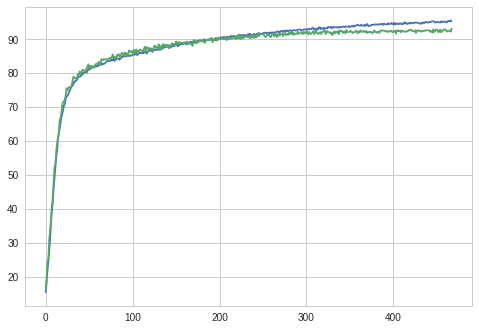

END_GAME


In [18]:
model=ANNV2()
model.cuda()
error = nn.CrossEntropyLoss()

#Adam Optimizer
learning_rate =0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.22,amsgrad=True)

count = 1
testloss=[]
loss_list = []
iteration_list = []
accuracy_list = []
accuracy_test=[]
counts=[]
correct=0
total=0
flag=1
preMax=0
epoch=0
flagchange=0
while True :
    correct=0
    total=0
    for images, labels in train_loader:
        
        train=Variable(images.float()).cuda()
        labels = Variable(labels).cuda()
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
       
        _,predicted = torch.max(outputs.data, 1)
        predicted=predicted.cuda()
        total = len(labels)
        correct = (predicted == labels).sum()
    epoch=epoch+1    
    accuracy = (100.0 *correct.float() / float(total)).float()
    accuracy_list.append(accuracy)
    if epoch%50==0:
        print("Accuracy train :{} ".format(accuracy))          
    correct=0
    total=0    
    for images, labels in test_loader:
        test=Variable(images.float()).cuda()
        labels = Variable(labels).cuda()
        outputs = model(test)
        teloss=error(outputs, labels)
        _,predicted = torch.max(outputs.data, 1)
        predicted=predicted.cuda()
        total = len(labels)
        correct = (predicted == labels).sum()
    accuracy = (100.0 *correct.float() / float(total)).float()
    accuracy_test.append(accuracy)
    
    if accuracy>=93 :
      state = {'epoch': count + 1,'state_dict': model.state_dict(),'optim_dict' : optimizer.state_dict()}
      save_checkpoint(state,False,"./drive/My Drive/DataSet/","bds02")
      print("Accuracy test :{} ".format(accuracy))
      plt.plot(range(0,len(accuracy_list)),accuracy_list)
      plt.plot(range(0,len(accuracy_test)),accuracy_test)
      plt.show()
      plt.pause(0.0001)
      break
      
    if epoch%500==0:
      plt.plot(range(0,epoch),accuracy_list)
      plt.plot(range(0,epoch),accuracy_test)
      plt.show()
      plt.pause(0.0001)
    if epoch%(50)==0:
      print("Accuracy test :{} ".format(accuracy))
      print('Iteration: {}  Loss: {}  Loss test: {} '.format(epoch, loss.data[0], teloss.data[0]))
   


print("END_GAME")

In [19]:
datatest=pd.read_csv("drive/My Drive/DataSet/test.csv");
datatest=datatest.drop(['Id','Content'],axis=1)
datatest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 2 columns):
Title                4994 non-null object
HouseTypeCssClass    4994 non-null object
dtypes: object(2)
memory usage: 78.1+ KB


In [20]:
datatest.head(5)

,Title,HouseTypeCssClass
0,"bán mt trần đình xu - trần hưng đạo, dt: 11.5x...",tp-house
1,"đất mặt tiền kqh vịnh mộc - bùi xuân phái,giá tốt",tp-none
2,"bán nhà trệt lững hẻm tổ 11. phường an khánh,",tp-house
3,nguyễnvăn sắt 7m5 bán nhanh cân tiền,tp-none
4,"góc 2mt lý thường kiệt, 110m2 cần cho thuê",tp-house


In [21]:
datatest['Title'] = datatest['Title'].apply(replace_words)
datatest.head(5)

,Title,HouseTypeCssClass
0,bán mt trần đình xu trần hưng đạo,tp-house
1,đất mặt tiền kqh vịnh mộc bùi xuân phái tốt,tp-none
2,bán nhà trệt lững hẻm tổ phường an khánh,tp-house
3,nguyễnvăn sắt bán nhanh cân tiền,tp-none
4,góc mt lý thường kiệt cần cho thuê,tp-house


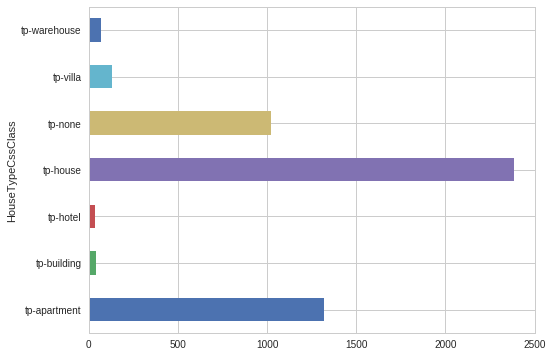

In [22]:
fig = plt.figure(figsize=(8,6))
datatest.groupby('HouseTypeCssClass').HouseTypeCssClass.count().plot.barh()
plt.show()

In [23]:
X_test_counts=count_vect.transform(datatest['Title'])
x_test=X_test_counts.toarray()
y_test=datatest['HouseTypeCssClass'].map({'tp-house': 0, 'tp-apartment': 1,'tp-none':2,'tp-villa':3,'tp-project':4,'tp-building':5,'tp-warehouse':6,'tp-others':7,'tp-hotel':8})
y_test=y_test.astype('float32').values
print(x_test.shape)

(4994, 2565)


In [33]:
datatest = torch.from_numpy(x_test).type(torch.LongTensor) 
valuetest = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long
datatest=Variable(datatest.float()).cuda()
valuetest=Variable(valuetest).cuda()
#load_checkpoint("./drive/My Drive/DataSet/bds02last.pth.tar", model, optimizer)
outputs = model(datatest)
_,predicted = torch.max(outputs.data, 1)
predicted=predicted.cuda()
total = len(valuetest)
correct = (predicted == valuetest).sum()
print("Correct {} in {} record".format(correct,datatest.shape[0]))
print("Accuracy: {}".format((100.0 *correct.float() / float(total)).float()))

Correct 4448 in 4994 record
Accuracy: 89.06687927246094
